In [ ]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

from diffusers import StableDiffusionPipeline

device = "cuda"
print("Device:", device)

In [2]:
# Load the pipeline
model_id = "/data_disk/dyy/stable-diffusion-2"
pipe = StableDiffusionPipeline.from_pretrained(model_id, revision="fp16", torch_dtype=torch.float16).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/data_disk/dyy/miniconda3/envs/Wz/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/35 [00:00<?, ?it/s]

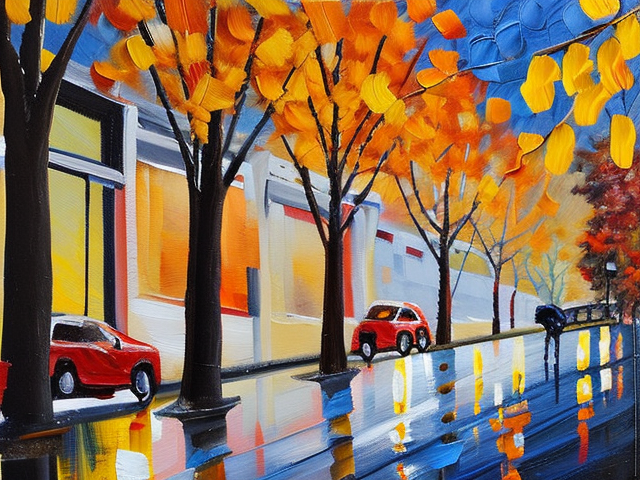

In [3]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=480, width=640,     # Specify the image size
    guidance_scale=8,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image:
pipe_output.images[0]

In [4]:
# 1. h, w must be divisible by 8 due to VAE
# 2. num_infererence_steps = 50 by default
# 3. negative prompt and guidance scale are related to classifer-free guidance(CFG)

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

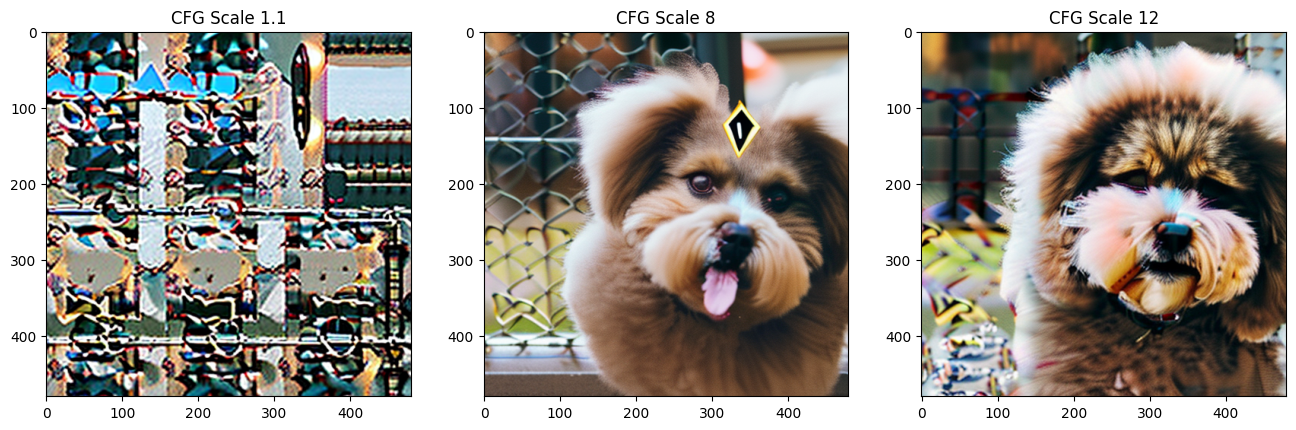

In [5]:
cfg_scales = [1.1, 8, 12]
prompt = "A fluffy dog with a rock star suits"
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
  im = pipe(prompt, height=480, width=480,
    guidance_scale=cfg_scales[i], num_inference_steps=35,
    generator=torch.Generator(device=device).manual_seed(42)).images[0]
  ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}');

# Pipeline Component

In [6]:
print(list(pipe.components))

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


## VAE (high level)

In [7]:
# Create some fake data (a random image, range (-1, 1))
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1 # （-1,1）
images = images.to(torch.float16)
print(images.shape)

torch.Size([1, 3, 512, 512])


In [8]:
# Encode to latent space
with torch.no_grad():
    latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean # 0.18215 scaling factor
print("Encoded latents shape:", latents.shape)

Encoded latents shape: torch.Size([1, 4, 64, 64])


In [9]:
# Decode again
with torch.no_grad():
  decoded_images = pipe.vae.decode(latents / 0.18215).sample 
print("Decoded images shape:", decoded_images.shape)

Decoded images shape: torch.Size([1, 3, 512, 512])


In [10]:
# dir(pipe.vae.encode(images).latent_dist)

## The Tokenizer and Text Encoder (high level)


In [11]:
# tokenizer # 50k sub-token    _encode_prompt  max 77 token
# mannually
# Tokenize
input_ids = pipe.tokenizer(["A painting of a dog"])["input_ids"]
print("Input ID -> decoded token")
for input_id in input_ids[0]:
  print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")


Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
1929 -> dog
49407 -> <|endoftext|>


In [14]:
# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
print(pipe.text_encoder(input_ids)['last_hidden_state'].shape)
print(pipe.text_encoder(input_ids)['pooler_output'].shape)  # 池化后的 [1, 1024]

with torch.no_grad():
    text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print('test embeddings shape:', text_embeddings.shape)

# Get the final text embeddings using the pipeline's _encode_prompt function
# 自行生成 prompt_embeds
prompt_embeds = pipe.text_encoder(input_ids)['last_hidden_state']
text_embeddings = pipe.encode_prompt(
    prompt=None,  # 因为我们已经提供了 prompt_embeds
    device=device,
    num_images_per_prompt=1,
    do_classifier_free_guidance=False,
    prompt_embeds=prompt_embeds,  # 使用手动生成的 prompt_embeds
)[0]


print(text_embeddings.shape)
#这里输出[1, 77, 1024],表示即便当前不够77的长度,也会填充0


torch.Size([1, 7, 1024])
torch.Size([1, 1024])
test embeddings shape: torch.Size([1, 7, 1024])
torch.Size([1, 7, 1024])


/tmp/ipykernel_1589468/2062849679.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids).to(device)


## UNet

In [18]:
# dummy_inputs:
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

In [19]:
# model prediction
with torch.no_grad():
    unet_output = pipe.unet(latents, timestep, text_embeddings).sample
# print('UNet output shape:', unet_output.shape)

RuntimeError: mat1 and mat2 must have the same dtype, but got Float and Half

## Scheduler

In [ ]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (high noise to low noise ->)');
plt.title('Noise schedule');plt.legend();

In [ ]:
# swapping scheduler
from diffusers import LMSDiscreteScheduler

# Replace the scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# Print the config
print('Scheduler config:', pipe.scheduler)

# Generate an image with this new scheduler
pipe(prompt="Palette knife painting of an winter cityscape", height=480, width=480,
     generator=torch.Generator(device=device).manual_seed(42)).images[0]

# DIY txt2img

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from PIL import Image
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [16]:
def plt_show_image(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [17]:
# pipe=StableDiffusionPipeline
# pipe.scheduler.init_noise_sigma

In [18]:
@torch.no_grad()
def generate_simplified(
    prompt = ["a lovely cat"],
    uncond_prompt = [""],
    num_inference_steps = 50,
    guidance_scale = 7.5,
    # do_classifier_free_guidance
    batch_size = 1,
    height = 512,
    width = 512,
    generator = None
    ):
        
    # get prompt text embeddings
    text_inputs = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        return_tensors="pt", 
    )

    text_input_ids = text_inputs.input_ids
    text_embeddings = pipe.text_encoder(text_input_ids.to(pipe.device))[0]
    bs_embed, seq_len, _ = text_embeddings.shape

    # get negative prompts  text embedding
    max_length = text_input_ids.shape[-1]
    uncond_input = pipe.tokenizer(
        uncond_prompt,
        padding="max_length",
        max_length=max_length,
        truncation=True,
        return_tensors="pt"
    )


    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(pipe.device))[0]

    # duplicate unconditional embeddings for each generation per prompt
    seq_len = uncond_embeddings.shape[1]
    uncond_embeddings = uncond_embeddings.repeat(batch_size, 1, 1) 
    uncond_embeddings = uncond_embeddings.view(batch_size, seq_len, -1)

    # concat
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    latants_shape = (batch_size, pipe.unet.in_channels, height//8, width//8)
    latents_dtype = text_embeddings.dtype
    latents = torch.randn(latants_shape, generator=generator, device=pipe.device, dtype=latents_dtype)

    # set timesteps
    pipe.scheduler.set_timesteps(num_inference_steps)
    timsteps_tensor = pipe.scheduler.timesteps.to(pipe.device)

    latents = latents * pipe.scheduler.init_noise_sigma

    # main diffusion process
    for i, t in enumerate(pipe.progress_bar(timsteps_tensor)):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
                   # uncond - guidance_scale * uncond + guidance_scale * cond
                   # (1 - guidance_scale) * uncond    + guidance_scale * 

        # compute the previous noisy sample x_t --》 x_t-1
        latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    latents = 1 / 0.18215 * latents
    image = pipe.vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)

    image = image.cpu().permute(0, 2, 3, 1).float().numpy()

    return image


In [19]:
if __name__ == "__main__":
    pipe = StableDiffusionPipeline.from_pretrained(
        "/data_disk/dyy/stable-diffusion-2",
        revision="fp16", # model version
        torch_dtype=torch.float16
    ).to("cuda")
        
    image = generate_simplified(
        prompt =["a lovely cat"]
    )

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_1651103/2285756950.py:47: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latants_shape = (batch_size, pipe.unet.in_channels, height//8, width//8)


  0%|          | 0/50 [00:00<?, ?it/s]

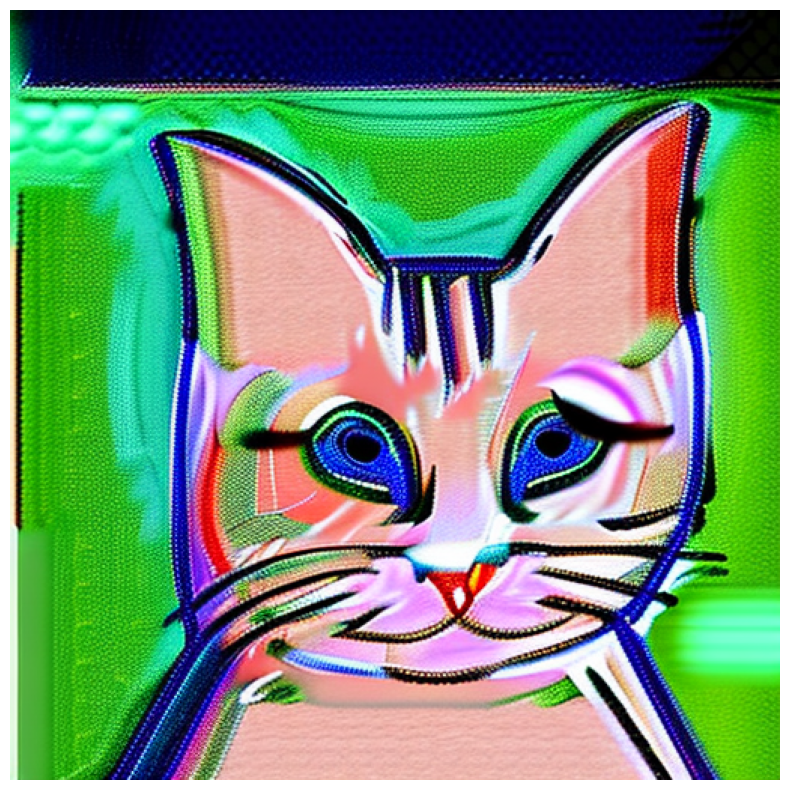

In [14]:
plt_show_image(image[0])

# img2img API

In [ ]:
# /mnt/mydrive/datas/model/Ghibli-Diffusion
import torch
import requests
from PIL import Image
from io import BytesIO
from diffusers import StableDiffusionImg2ImgPipeline
import matplotlib.pyplot as plt

device = "cuda"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained("/mnt/mydrive/datas/model/Ghibli-Diffusion", torch_dtype=torch.float16).to(
    device
)

init_image = Image.open("./landscape.jpg").convert("RGB")
init_image.thumbnail((768, 768))
init_image

In [ ]:
prompt = "ghibli style, a fantasy landscape with castles"
generator = torch.Generator(device=device).manual_seed(1024)
image = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5, generator=generator, num_inference_steps=50).images[0]
image

In [ ]:
from diffusers import LMSDiscreteScheduler

lms = LMSDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = lms
generator = torch.Generator(device=device).manual_seed(1024)
image = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5, generator=generator).images[0]
image

In [ ]:
init_image = Image.open("./dog.png")# .convert("RGB")

result_image = pipe(
    prompt="An oil painting of a man on a bench",
    image = init_image, # The starting image
    strength = 0.6, # 0 for no change, 1.0 for max strength
).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(result_image);axs[1].set_title('Result');

# Inpaiting API

In [ ]:
from diffusers import StableDiffusionInpaintPipeline

# In-Painting
# Load the inpainting pipeline (requires a suitable inpainting model)
pipe = StableDiffusionInpaintPipeline.from_pretrained("/mnt/mydrive/datas/model/stable-diffusion-inpainting")
pipe = pipe.to(device)

In [ ]:
img_path = f"./dog.png"
mask_path = f"./dog_mask.png"

img = Image.open(img_path)
mask = Image.open(mask_path)

prompt = "A small robot, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=img, mask_image=mask).images[0]

# View the result
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(img);axs[0].set_title('Input Image')
axs[1].imshow(mask);axs[1].set_title('Mask')
axs[2].imshow(image);axs[2].set_title('Result');

# DIY img2img

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline
import torch
import torchvision.transforms as transforms
import PIL
from PIL import Image
import matplotlib.pyplot as plt


def plt_show_image(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def seed_everything(seed=42):
    import torch
    import numpy as np
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def save_image(image, filename):
    img = Image.fromarray((image * 255).astype('uint8'))
    img.save(filename)

@torch.no_grad()
def preprocess(image):
    preprocess_pipeline = transforms.Compose([
        transforms.Resize(512), # Resize to the same size as your model input
        transforms.ToTensor(), # Convert PIL image to Torch tensor
    ])
    image_tensor = preprocess_pipeline(image)
    image_tensor.unsqueeze_(0)  # Add batch dimension
    return image_tensor


In [ ]:
@torch.no_grad()
def generate_img2img_simplified(
    prompt,
    init_image,
    uncond_prompt = [""],
    strength = 0.8, # strength of the image conditioning
    batch_size = 1,
    num_inference_steps = 50,
    do_classifier_free_guidance = True,
    guidance_scale = 7.5
):

    # set timesteps
    pipe.scheduler.set_timesteps(num_inference_steps)

    # get prompt text embeddings
    text_inputs = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids
    text_embeddings = pipe.text_encoder(text_input_ids.to(pipe.device))[0]

    # get unconditional embeddings for classifier free guidance
    uncond_tokens = uncond_prompt
    max_length = text_input_ids.shape[-1]
    uncond_input = pipe.tokenizer(
        uncond_tokens,
        padding="max_length",
        max_length=max_length,
        truncation=True,
        return_tensors="pt",
    )
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(pipe.device))[0]

    # classifier free guidance
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    #####################################################################
    # encode the init image into latents and scale the latents
    latents_dtype = text_embeddings.dtype
    if isinstance(init_image, PIL.Image.Image):
        init_image = preprocess(init_image)
    init_image = init_image.to(device=pipe.device, dtype=latents_dtype)
    init_latent_dist = pipe.vae.encode(init_image).latent_dist
    init_latents = init_latent_dist.sample()
    init_latents = 0.18215 * init_latents
    #####################################################################

    # get the original timestep using init_timestep
    offset = pipe.scheduler.config.get("steps_offset", 0)
    init_timestep = int(num_inference_steps * strength) + offset
    init_timestep = min(init_timestep, num_inference_steps)

    timesteps = pipe.scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps] * batch_size, device=pipe.device)

    # add noise to latents using the timesteps
    noise = torch.randn(init_latents.shape, device=pipe.device, dtype=latents_dtype)
    init_latents = pipe.scheduler.add_noise(init_latents, noise, timesteps)

    latents = init_latents

    t_start = max(num_inference_steps - init_timestep + offset, 0)
    # Some schedulers like PNDM have timesteps as arrays
    # It's more optimized to move all timesteps to correct device beforehand
    timesteps = pipe.scheduler.timesteps[t_start:].to(pipe.device)

    for i, t in enumerate(pipe.progress_bar(timesteps)):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    latents = 1 / 0.18215 * latents
    image = pipe.vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).float().numpy()
    return image
    

In [ ]:
# seed_everything(1024)
device = "cuda"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained( 
    "/mnt/mydrive/datas/model/Ghibli-Diffusion",
    revision="fp16",  torch_dtype=torch.float16,
).to(device)

# Load the initial image if required.
init_image = Image.open("./landscape.png")


In [ ]:
# Now we can use the function to generate an image.
with torch.no_grad():
    image = generate_img2img_simplified(
        prompt = ["ghibli style, a fantasy landscape with castles"],
        uncond_prompt = [""],
        init_image = init_image,
        strength = 0.75,
        batch_size = 1,
    )
plt_show_image(image[0])